# Libraries and declared functions


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import graphviz
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.model_selection import train_test_split, validation_curve, GridSearchCV
from sklearn.linear_model import ElasticNet, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_log_error
import numpy as np
from scipy.stats import randint
%matplotlib inline

In [ ]:
def get_splitted_data(data, targets, test_size):
    
    X_train, X_test, y_train, y_test = train_test_split(data, targets, 
                                                        test_size=test_size,
                                                        random_state=42)
    
    return X_train, X_test, y_train, y_test


In [ ]:
def get_data_for_validation_curve(model, X_train, y_train, depths_range, cv=5):
    
    train_score, valid_score = validation_curve(model,
                                                 X_train, y_train,
                                                 param_name='max_depth',
                                                 param_range=depths_range,
                                                 cv=cv)
    return train_score, valid_score

In [ ]:
def plot_validation_curve(x, y_train, y_cvs, best_depth, title='Score', ):
    plt.figure(figsize=(12, 7))
    plt.plot(x, y_train)
    plt.plot(x, y_cvs)
    plt.plot(best_depth, y_cvs[best_depth - 1], marker='o', color='black')
    plt.title(title)
    plt.xlabel('Depth')
    plt.ylabel('Score (max=1)')
    plt.legend(['Train', 'Cross-validation', 
                'Best score = {:.03f}'.format(y_cvs[best_depth - 1])])
    plt.xticks(x)
    plt.grid()
    plt.show()
    

In [ ]:
def get_final_tree_and_score(tree_model, X_train, X_test, y_train, y_test):
    regressor_tree = tree_model
    regressor_tree.fit(X_train, y_train)
    final_score = regressor_tree.score(X_test, y_test)
    return regressor_tree, final_score
        

In [ ]:
def print_validation_graph(trainScores, validScores, depth_range):
    train_scores_mean = []
    valid_scores_mean = []
    
    for i in range(len(depth_range)):
        train_scores_mean.append(np.mean(trainScores[i]))
        valid_scores_mean.append(np.mean(validScores[i]))
        
    best_depth = depth_range[np.argmax(valid_scores_mean) - 1]
    
    plot_validation_curve(depth_range, train_scores_mean, valid_scores_mean, best_depth)
    
    return best_depth, train_scores_mean, valid_scores_mean

# Data analysis

In [ ]:
df = pd.read_csv('/home/marcin/Documents/Project Wojtek/Bike-Sharing-Dataset/hour.csv',
                      encoding = "ISO-8859-1")

df.describe()

df_2012 = df.loc[df['yr']==1]

# X = df_2012[['season', 'mnth', 'hr', 'holiday', 
#         'weekday', 'workingday', 'weathersit',
#         'temp', 'atemp', 'hum', 'windspeed']]

# y = df_2012[['cnt']]

# depths = range(1, 25)

# X_train, X_test, y_train, y_test = get_splitted_data(X, y, 0.2)

## Data description

In [ ]:
df.describe()

,instant,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,17379.0000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,8690.0000,2.501640,0.502561,6.537775,11.546752,0.028770,3.003683,0.682721,1.425283,0.496987,0.475775,0.627229,0.190098,35.676218,153.786869,189.463088
std,5017.0295,1.106918,0.500008,3.438776,6.914405,0.167165,2.005771,0.465431,0.639357,0.192556,0.171850,0.192930,0.122340,49.305030,151.357286,181.387599
min,1.0000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,4345.5000,2.000000,0.000000,4.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.480000,0.104500,4.000000,34.000000,40.000000
50%,8690.0000,3.000000,1.000000,7.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.194000,17.000000,115.000000,142.000000
75%,13034.5000,3.000000,1.000000,10.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.621200,0.780000,0.253700,48.000000,220.000000,281.000000
max,17379.0000,4.000000,1.000000,12.000000,23.000000,1.000000,6.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,367.000000,886.000000,977.000000


## Rented bikes per annum

In [ ]:
year_2011 = df.loc[df['yr']==0].sum(axis=0)
year_2012 = df.loc[df['yr']==1].sum(axis=0)

/home/marcin/anaconda3/envs/tensorflow/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,casual,registered,cnt
yr,,,
2011,247252,995851,1243103
2012,372765,1676811,2049576


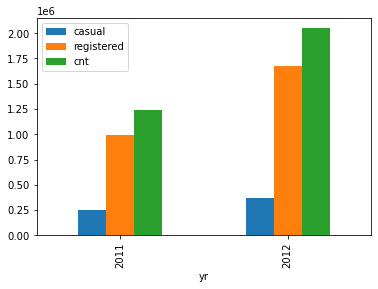

In [ ]:
df_year = df.groupby(['yr'])['casual', 'registered', 'cnt'].sum()

df_year = df_year.rename(index={0: '2011', 1: '2012'})

df_year[['casual', 'registered', 'cnt']].plot(kind='bar')

df_year.head()

It is easy to notice increase in demand, what should be accounted for in the predicitve model for the future.

## Rented bikes per season

/home/marcin/anaconda3/envs/tensorflow/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


casual  registered     cnt
yr   season                            
2011 spring   21425      128575  150000
     summer   77564      269752  347316
     fall     95450      324200  419650
     winter   52813      273324  326137
2012 spring   39197      282151  321348
     summer  125958      445315  571273
     fall    130641      510838  641479
     winter   76969      438507  515476

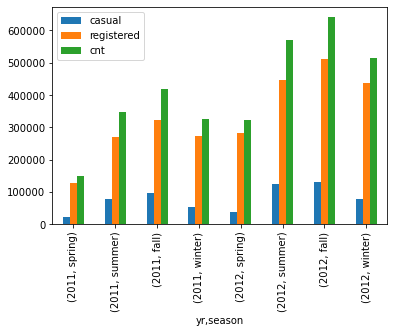

In [ ]:
df_seasons = df.groupby(['yr', 'season'])['casual', 'registered', 'cnt'].sum()

df_seasons = df_seasons.rename(index={0: 2011, 1: 2012}, level=0)
df_seasons = df_seasons.rename(index={1: 'spring', 2: 'summer', 3: 'fall', 4: 'winter'}, level=1)
# df_seasons = df_seasons.rename(columns={'cnt': 'total amount'})

df_seasons[['casual', 'registered', 'cnt']].plot(kind='bar')

df_seasons

## Rented bikes count depending on weather condition

In [ ]:
df_unnormalized = df.copy()
df_unnormalized['temp'] = df_unnormalized['temp'].apply(lambda x: x * 41)
df_unnormalized['atemp'] = df_unnormalized['atemp'].apply(lambda x: x * 50)
df_unnormalized['hum'] = df_unnormalized['hum'].apply(lambda x: x * 100)
df_unnormalized['windspeed'] = df_unnormalized['windspeed'].apply(lambda x: x * 67)

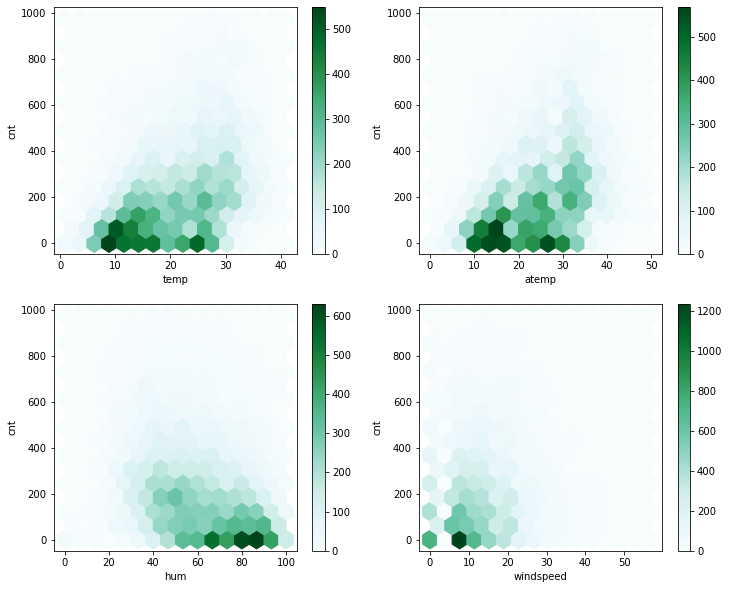

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

ax1 = df_unnormalized.plot.hexbin(x='temp', y='cnt', gridsize=15, sharex=False,
                                  ax=axes[0, 0])
ax2 = df_unnormalized.plot.hexbin(x='atemp', y='cnt', gridsize=15, sharex=False,
                                  ax=axes[0, 1])
ax3 = df_unnormalized.plot.hexbin(x='hum', y='cnt', gridsize=15, sharex=False,
                                  ax=axes[1, 0])
ax4 = df_unnormalized.plot.hexbin(x='windspeed', y='cnt', gridsize=15, sharex=False,
                                  ax=axes[1, 1])

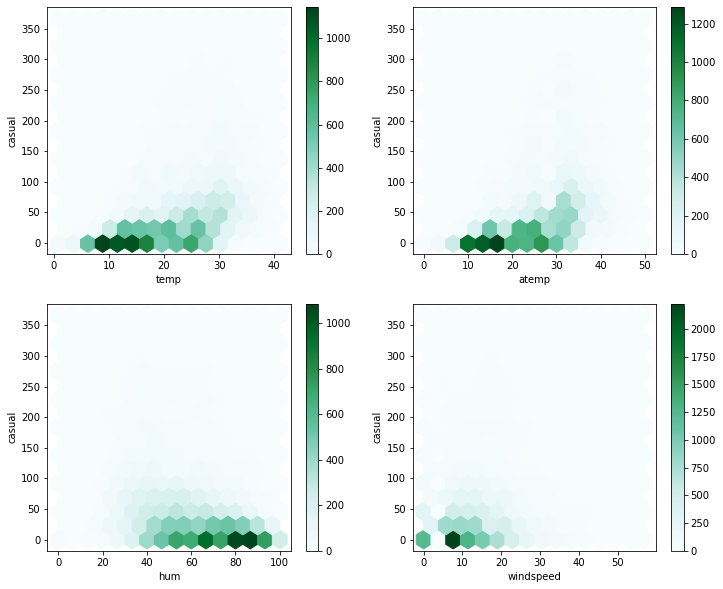

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

ax1 = df_unnormalized.plot.hexbin(x='temp', y='casual', gridsize=15, sharex=False,
                                  ax=axes[0, 0])
ax2 = df_unnormalized.plot.hexbin(x='atemp', y='casual', gridsize=15, sharex=False,
                                  ax=axes[0, 1])
ax3 = df_unnormalized.plot.hexbin(x='hum', y='casual', gridsize=15, sharex=False,
                                  ax=axes[1, 0])
ax4 = df_unnormalized.plot.hexbin(x='windspeed', y='casual', gridsize=15, sharex=False,
                                  ax=axes[1, 1])

# Mitigating the influence of differences in demand over two years

For mitigating efect I will artificially increase rented bikes's count in each 2011's sample by multiplying its value, according to formula below:


```
rented_bikes_in_2012 = df_seasons.loc['2012', season]['cnt'] 

rented_bikes_in_2011 = df_seasons.loc['2011', season]['cnt']

ratio = rented_bikes_in_2012 / rented_bikes_in_2011
```
We possibly can assume linear increase in demand. To be certain, it is advised to get more data from years predate the 2011. At least three points are required to determine linearinty or nonlinearity. 




In [ ]:
df_seasons

casual  registered     cnt
yr   season                            
2011 spring   21425      128575  150000
     summer   77564      269752  347316
     fall     95450      324200  419650
     winter   52813      273324  326137
2012 spring   39197      282151  321348
     summer  125958      445315  571273
     fall    130641      510838  641479
     winter   76969      438507  515476

In [ ]:
df_2013 = df.copy()

In [ ]:
df_2013.loc[(df_2013['season']==2) & (df_2013['yr']==1)]['cnt']

10557     33
10558     26
10559     10
10560      8
10561      4
        ... 
12758    539
12759    407
12760    344
12761    257
12762    123
Name: cnt, Length: 2206, dtype: int64

In [ ]:
seasons = ['spring', 'summer', 'fall', 'winter']
i = 1

for season in seasons:

  rented_bikes_in_2012 = df_seasons.loc[2012, season]['cnt'] 
  rented_bikes_in_2011 = df_seasons.loc[2011, season]['cnt']

  ratio_season = rented_bikes_in_2012 / rented_bikes_in_2011
  print(ratio_season)

  df_2013.loc[(df_2013['season']==i) & (df_2013['yr']==1), 'cnt'] = round(df_2013['cnt'] * ratio_season)
  
  df_2013.loc[(df_2013['season']==i) & (df_2013['yr']==0), 'cnt'] = round(df_2013['cnt'] * (ratio_season ** 2))
  i += 1

2.14232
1.6448220064724919
1.5286047897057071
1.5805505048491892


In [ ]:
df_2013.loc[(df_2013['season']==2) & (df_2013['yr']==1), 'cnt']

10557     54.0
10558     43.0
10559     16.0
10560     13.0
10561      7.0
         ...  
12758    887.0
12759    669.0
12760    566.0
12761    423.0
12762    202.0
Name: cnt, Length: 2206, dtype: float64

# Decision tree regressor with validation curve


In [ ]:
X = df_2013[['season', 'mnth', 'hr', 'holiday', 
        'weekday', 'workingday', 'weathersit',
        'temp', 'atemp', 'hum', 'windspeed']]

y = df_2013[['cnt']]

depths = range(1, 25)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=42)

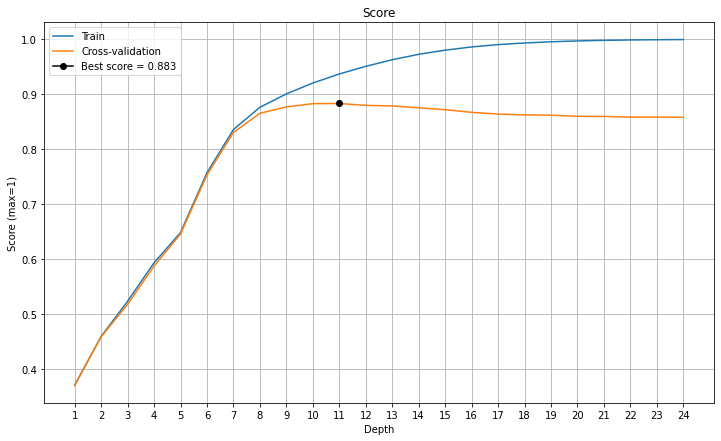


Best depth = 11
Train score = 0.937
Cross-validation score = 0.883

Test score = 0.854
msle = 0.18042515044266963


In [ ]:
train_scores, valid_scores = get_data_for_validation_curve(DecisionTreeRegressor(),
                                                           X_train,
                                                           y_train,
                                                           depths)

best_depth, train_scores_mean, valid_scores_mean = print_validation_graph(train_scores,
                                                                          valid_scores,
                                                                          depths)


print("""
Best depth = {}
Train score = {:.3f}
Cross-validation score = {:.3f}
""".format(best_depth, train_scores_mean[best_depth - 1],
valid_scores_mean[best_depth - 1]))


regressor_tree, test_score = get_final_tree_and_score(
                                DecisionTreeRegressor(max_depth=best_depth), 
                                X_train, X_test, y_train, y_test)

print("Test score = {:.3f}".format(test_score))

test_predictions = regressor_tree.predict(X_test)

test_msle = mean_squared_log_error(y_test, test_predictions)
print('msle =', test_msle)

# Random forest regresson with hyperparameter tunning

In [ ]:
clf_randomForest = RandomForestRegressor()

y_train_numpy = y_train.to_numpy()
y_train_numpy = np.ravel(y_train_numpy)

y_test_numpy = y_test.to_numpy()
y_test_numpy = np.ravel(y_test_numpy)

param_dist = {
    "n_estimators": range(50, 201, 15),
    "max_depth": range(10, 21, 2),
    "max_features": ['auto', 'sqrt', 'log2'],
    "min_samples_split": [2, 3, 5, 8, 10, 13],
    }

# gs = GridSearchCV(estimator=clf_randomForest, param_grid=param_dist, verbose=2, cv=5)

# gs.fit(X_train, y_train_numpy)



In [ ]:
gs.best_score_

In [ ]:
best_params_forest = gs.best_params_

In [ ]:
best_params_forest

In [ ]:
regressor_tree, test_score = get_final_tree_and_score(RandomForestRegressor(max_depth=16,
                                                                            max_features='auto',
                                                                            min_samples_split=4,
                                                                            n_estimators=90),  
                                                      X_train, X_test,
                                                      y_train_numpy, y_test_numpy)

print("r2_score [test set] = {:.3f}".format(test_score))

r2 score [test set] = 0.923


In [ ]:
test_predictions_forest = regressor_tree.predict(X_test)

msle_best_forest = mean_squared_log_error(y_test, test_predictions_forest)

print('msle =', msle_best_forest)

msle = 0.13283043633787922


# Random forest regressor with validation curve

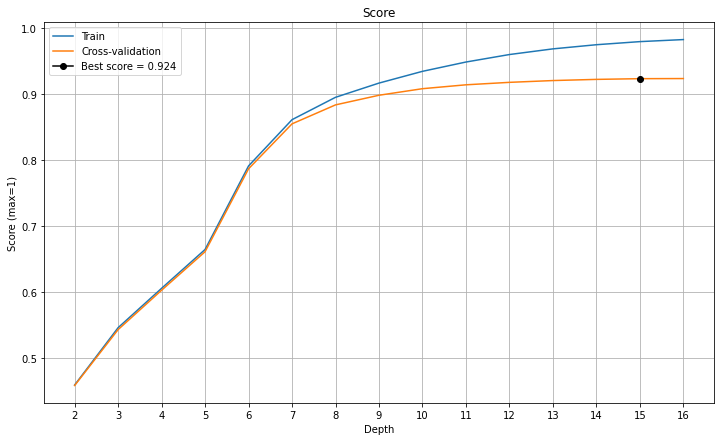


Best depth = 15
Train score = 0.983
Cross-validation score = 0.924

Test score = 0.924


In [ ]:
depths = range(2, 17)

train_scores_forest, valid_scores_forest = get_data_for_validation_curve(clf_randomForest,
                                                           X_train,
                                                           y_train_numpy,
                                                           depths)

best_depth, train_scores_mean_forest, valid_scores_mean_forest = print_validation_graph(
                                                                      train_scores_forest, 
                                                                      valid_scores_forest,
                                                                      depths
                                                                      )


print("""
Best depth = {}
Train score = {:.3f}
Cross-validation score = {:.3f}
""".format(best_depth, train_scores_mean_forest[best_depth - 1],
valid_scores_mean_forest[best_depth - 1]))


regressor_tree, test_score = get_final_tree_and_score(
    RandomForestRegressor(), X_train, X_test, y_train_numpy, y_test_numpy)

print("Test score = {:.3f}".format(test_score))

test_predictions = regressor_tree.predict(X_test)

# Neural Network

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import RMSprop

In [ ]:
def build_model(input_shape):
    model = tf.keras.models.Sequential([
        Dense(32, activation='relu', input_shape=input_shape),
        Dense(32, activation='relu'),
        Dense(1, activation='relu')
        ])
    model.compile(optimizer=RMSprop(learning_rate=10e-3), loss='msle', metrics=['msle'])
    return model

In [ ]:
input_shape = (X_train.shape[1],)

model = build_model(input_shape)

In [ ]:
history = model.fit(X_train, y_train, batch_size=32, epochs=25)

Epoch 1/25
435/435 [==============================] - 1s 2ms/step - loss: 1.1749 - msle: 1.1749
Epoch 2/25
435/435 [==============================] - 1s 2ms/step - loss: 0.5624 - msle: 0.5624
Epoch 3/25
435/435 [==============================] - 1s 2ms/step - loss: 0.4533 - msle: 0.4533
Epoch 4/25
435/435 [==============================] - 1s 2ms/step - loss: 0.3999 - msle: 0.3999
Epoch 5/25
435/435 [==============================] - 1s 2ms/step - loss: 0.3735 - msle: 0.3735
Epoch 6/25
435/435 [==============================] - 1s 2ms/step - loss: 0.3535 - msle: 0.3535
Epoch 7/25
435/435 [==============================] - 1s 1ms/step - loss: 0.3355 - msle: 0.3355
Epoch 8/25
435/435 [==============================] - 1s 2ms/step - loss: 0.3318 - msle: 0.3318
Epoch 9/25
435/435 [==============================] - 1s 2ms/step - loss: 0.3237 - msle: 0.3237
Epoch 10/25
435/435 [==============================] - 1s 2ms/step - loss: 0.3172 - msle: 0.3172
Epoch 11/25
435/435 [==================

In [ ]:
val_mse, val_mae = model.evaluate(X_test, y_test, verbose=0)
print("MSE =", val_mse, "\nMAE =", val_mae)

MSE = 0.21819937229156494 
MAE = 0.21819937229156494


In [ ]:
y_predicted = model.predict(X_test)
y_predicted.min()

7.1962023

In [ ]:
r2 = r2_score(y_test, y_predicted)
print('r2 score =', r2)

r2 score = 0.6872178471578956


In [ ]:
msle = mean_squared_log_error(y_test, y_predicted)
print(msle)

0.21819940969055837
